# AQI Trends - Patterns, Anomalies, and Environmental Insights

## Analysis Sequence

In [375]:
#Installing the required libraries
!pip install missingno
!pip install termcolor

In [376]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import numpy as np

import random as rd
import scipy
import scipy.stats as stats
from scipy.stats import boxcox
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import datetime as dt

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic


plt.style.use('seaborn-whitegrid')

from termcolor import colored

from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from itertools import combinations

## 1. Load the Dataset

In [377]:
df=pd.read_csv('city_day.csv')
df

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.920,18.220,17.150,NaN,0.920,27.640,133.360,0.000,0.020,0.000,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.970,15.690,16.460,NaN,0.970,24.550,34.060,3.680,5.500,3.770,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.400,19.300,29.700,NaN,17.400,29.070,30.700,6.800,16.400,2.250,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.700,18.480,17.970,NaN,1.700,18.590,36.080,4.430,10.140,1.000,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.100,21.420,37.760,NaN,22.100,39.330,39.310,7.010,18.890,2.780,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000,Good
29527,Visakhapatnam,2020-06-28,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000,Satisfactory
29528,Visakhapatnam,2020-06-29,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000,Satisfactory
29529,Visakhapatnam,2020-06-30,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000,Satisfactory


## 2. Explanation of the variables

CITY NAME : Name of the City

DATE: Includes all dates from 2015 to 2020

PM2.5: Particulate Matter 2.5-micrometer in ug / m3

PM10: Particulate Matter 10-micrometer in ug / m3

NO: Nitric Oxide in ug / m3

NO2: Nitric Dioxide in ug / m3

NOx: Any Nitric x-oxide in ppb

NH3: Ammonia in ug / m3

CO: Carbon Monoxide in ug / m3

SO2: Sulphur Dioxide in ug / m3

O3: Ozone in ug / m3

BENZENE: Benzene in ug / m3

TOULENE: Toluene in ug / m3

XYLENE: Xylene in ug / m3

AQI: Air Quality Index

AQI_Bucket: Air Quality Classification

In [378]:
#Summary
print(df.info())
print('\n')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB
None


          PM2.5      PM10        NO       NO2       NOx       NH3        CO  \
count 24933.00

## 3. Data Cleaning

### 3a. Checking for Null Rows in the Dataset
#### We check if there any rows that are completely null in the dataset consequently removing them as they do not add information to the model. As we can see there are no null rows in the dataset.

In [379]:
# Check for rows with all null values
null_rows = df[df.isnull().all(axis=1)]

# Display the rows with all null values
print("Rows with all null values:")
print('\n')
print(null_rows)

Rows with all null values:


Empty DataFrame
Columns: [City, Date, PM2.5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3, Benzene, Toluene, Xylene, AQI, AQI_Bucket]
Index: []


### 3b. Checking for Duplicate Rows in the Dataset
#### We check if there any duplicate rows in the dataset, if present we remove them as a part of Data Cleaning. As we can see there are no duplicate rows in the dataset.

In [380]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Display the duplicate rows
print("Duplicate Rows:")
print('\n')
print(duplicate_rows)

Duplicate Rows:


Empty DataFrame
Columns: [City, Date, PM2.5, PM10, NO, NO2, NOx, NH3, CO, SO2, O3, Benzene, Toluene, Xylene, AQI, AQI_Bucket]
Index: []


### 3c. Dropping the Rows with Y Variable (AQI) as Null
#### We check if there are any rows that have the AQI field as NaN as that is the Y variable we aim to predict using regression, We drop all the rows that have Null in the AQI Field.

In [381]:
df=df.dropna(subset=['AQI'])
df

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
28,Ahmedabad,2015-01-29,83.130,NaN,6.930,28.710,33.720,NaN,6.930,49.520,59.760,0.020,0.000,3.140,209.000,Poor
29,Ahmedabad,2015-01-30,79.840,NaN,13.850,28.680,41.080,NaN,13.850,48.490,97.070,0.040,0.000,4.810,328.000,Very Poor
30,Ahmedabad,2015-01-31,94.520,NaN,24.390,32.660,52.610,NaN,24.390,67.390,111.330,0.240,0.010,7.670,514.000,Severe
31,Ahmedabad,2015-02-01,135.990,NaN,43.480,42.080,84.570,NaN,43.480,75.230,102.700,0.400,0.040,25.870,782.000,Severe
32,Ahmedabad,2015-02-02,178.330,NaN,54.560,35.310,72.800,NaN,54.560,55.040,107.380,0.460,0.060,35.610,914.000,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000,Good
29527,Visakhapatnam,2020-06-28,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000,Satisfactory
29528,Visakhapatnam,2020-06-29,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000,Satisfactory
29529,Visakhapatnam,2020-06-30,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000,Satisfactory


### 3d. Distribution Analysis
#### We plot a grid KDE to determine the distribution of each feature. This includes the numerical features other than the Y variable (AQI).

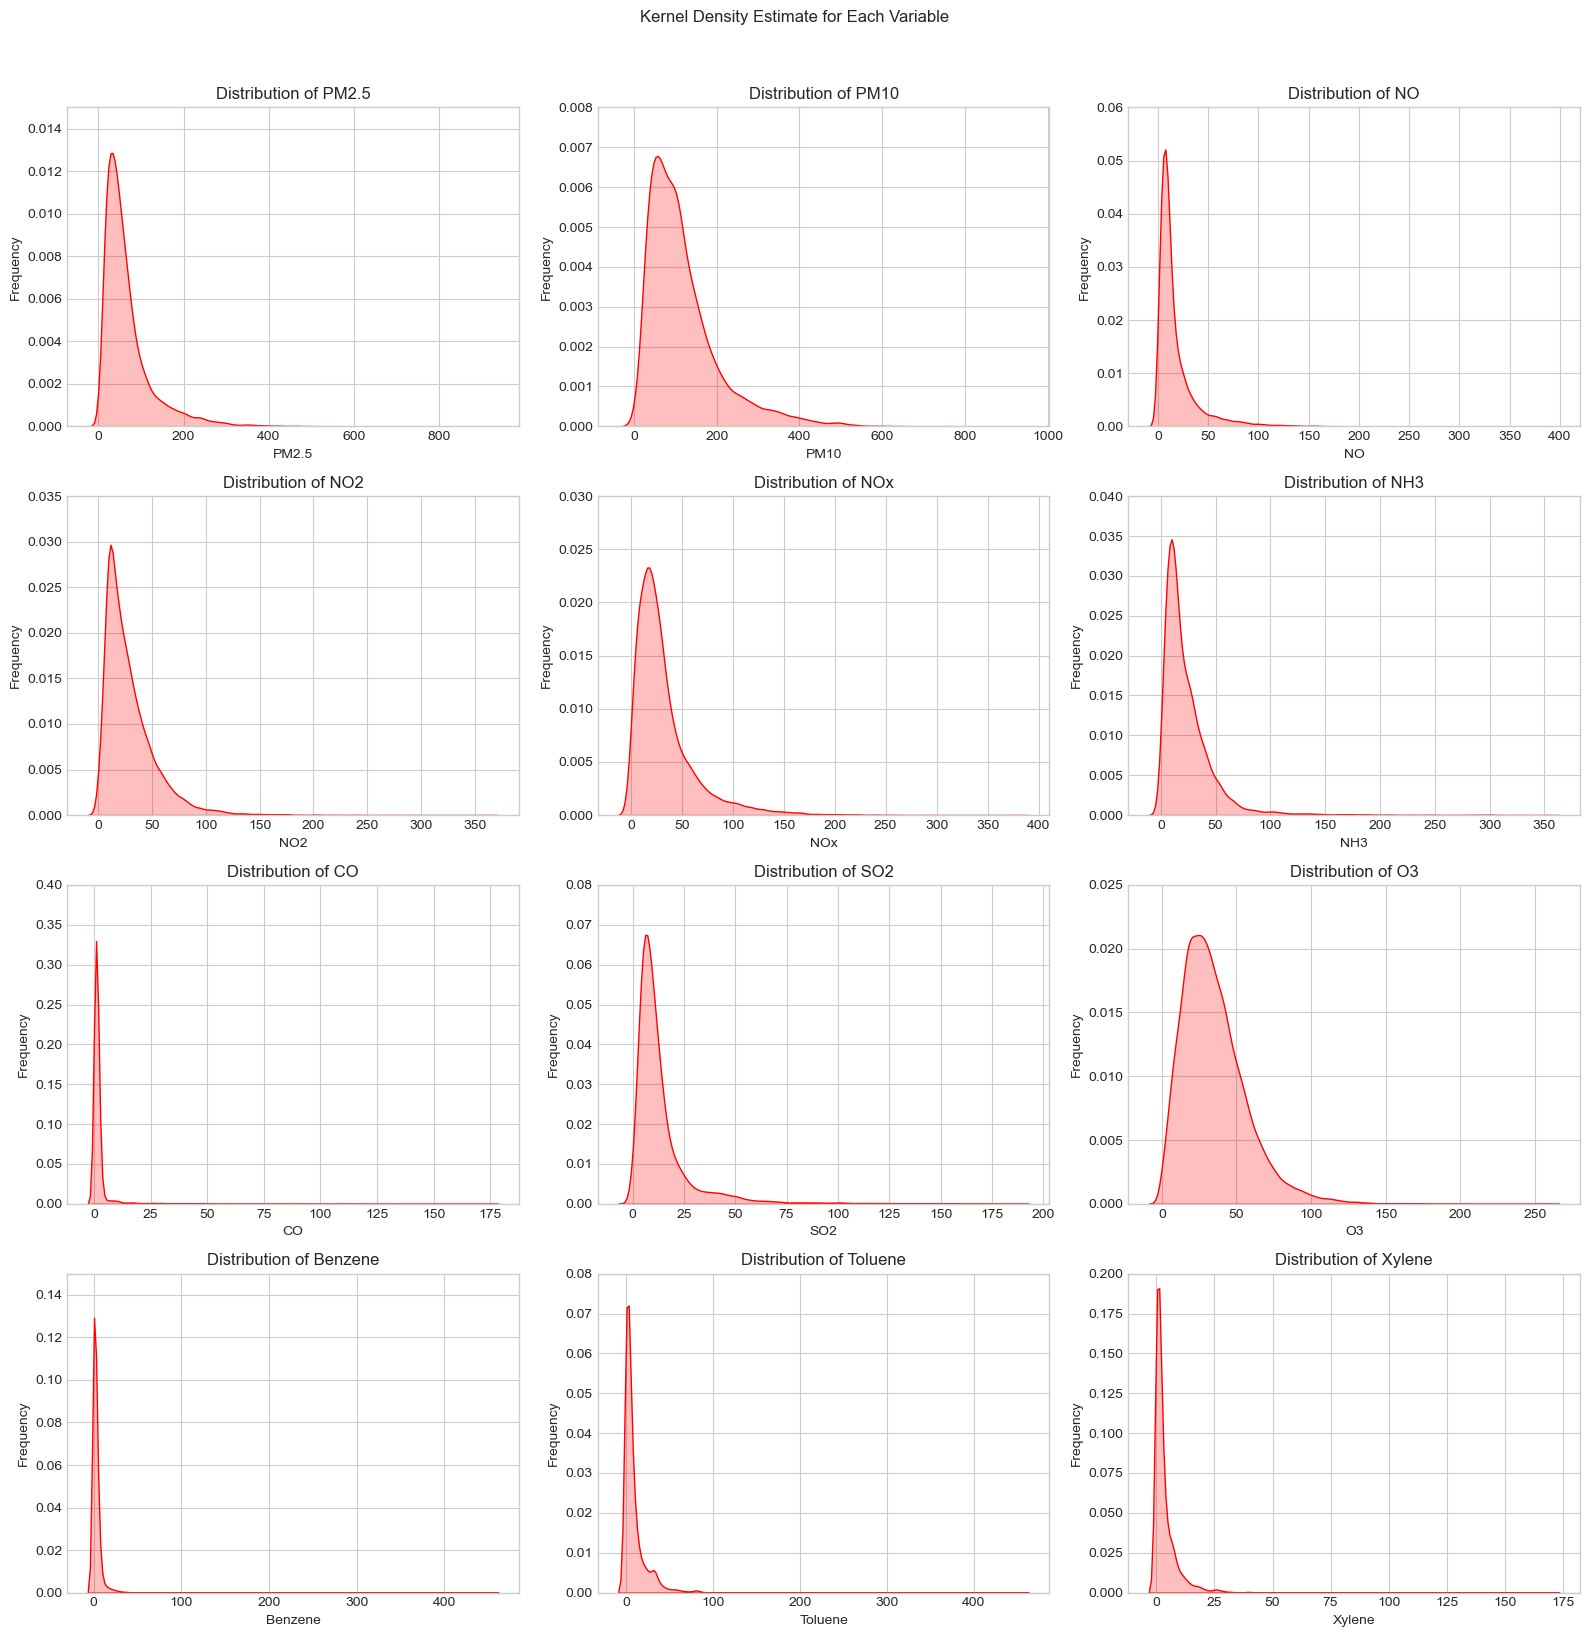

In [382]:
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2','O3', 'Benzene', 'Toluene', 'Xylene']

fig, axes = plt.subplots(4,3, figsize=(16, 16), sharey=False)
fig.suptitle('Kernel Density Estimate for Each Variable', y=1.02)

axes = axes.flatten()

y_axis_limits = [(0, 0.015), (0, 0.008), (0, 0.06), (0, 0.035),
                 (0, 0.03), (0, 0.04), (0, 0.4), (0, 0.08),
                 (0, 0.025), (0, 0.15), (0, 0.08), (0, 0.2)]

for i, (col, ylim) in enumerate(zip(features, y_axis_limits)):
    sns.kdeplot(data=df, x=col, color='red', ax=axes[i], fill=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_ylim(ylim)

plt.tight_layout()
plt.show()

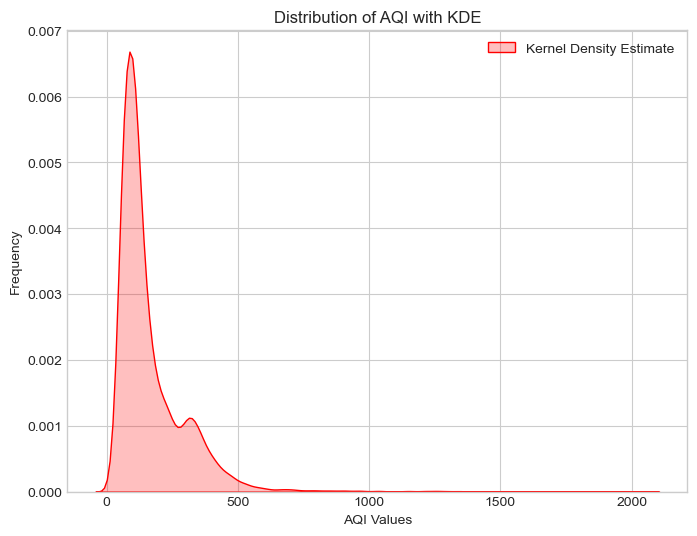

In [383]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df['AQI'], color='red', label='Kernel Density Estimate', fill=True)
plt.title('Distribution of AQI with KDE')
plt.xlabel('AQI Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

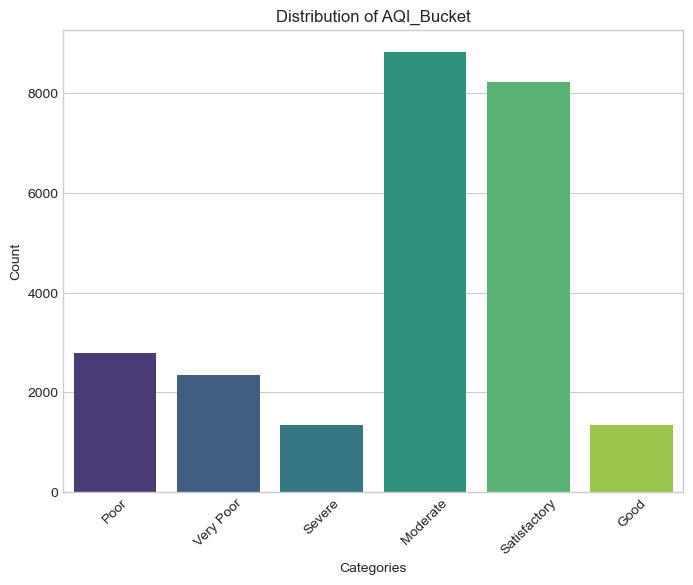

In [384]:
# Assuming df is your DataFrame and 'categorical_column' is the categorical column
plt.figure(figsize=(8, 6))

# Plot bar plot
sns.countplot(x='AQI_Bucket', data=df, palette='viridis')

plt.title('Distribution of AQI_Bucket')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

### 3e. Handling Missing Values

#### We find the proportion of missing values in the dataset for each column. This table gives us the number of missing values and their percentage. 

#### The table shows that there is a large amount of missing values in the dataset and we need to fill these before proceeding for Regression.

In [385]:
missing_values_table(df)

Your selected dataframe has 16 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
Xylene,15372,61.900
PM10,7086,28.500
NH3,6536,26.300
Toluene,5826,23.400
Benzene,3535,14.200
NOx,1857,7.500
O3,807,3.200
PM2.5,678,2.700
SO2,605,2.400
CO,445,1.800


#### Missing Values Matrix

<Axes: >

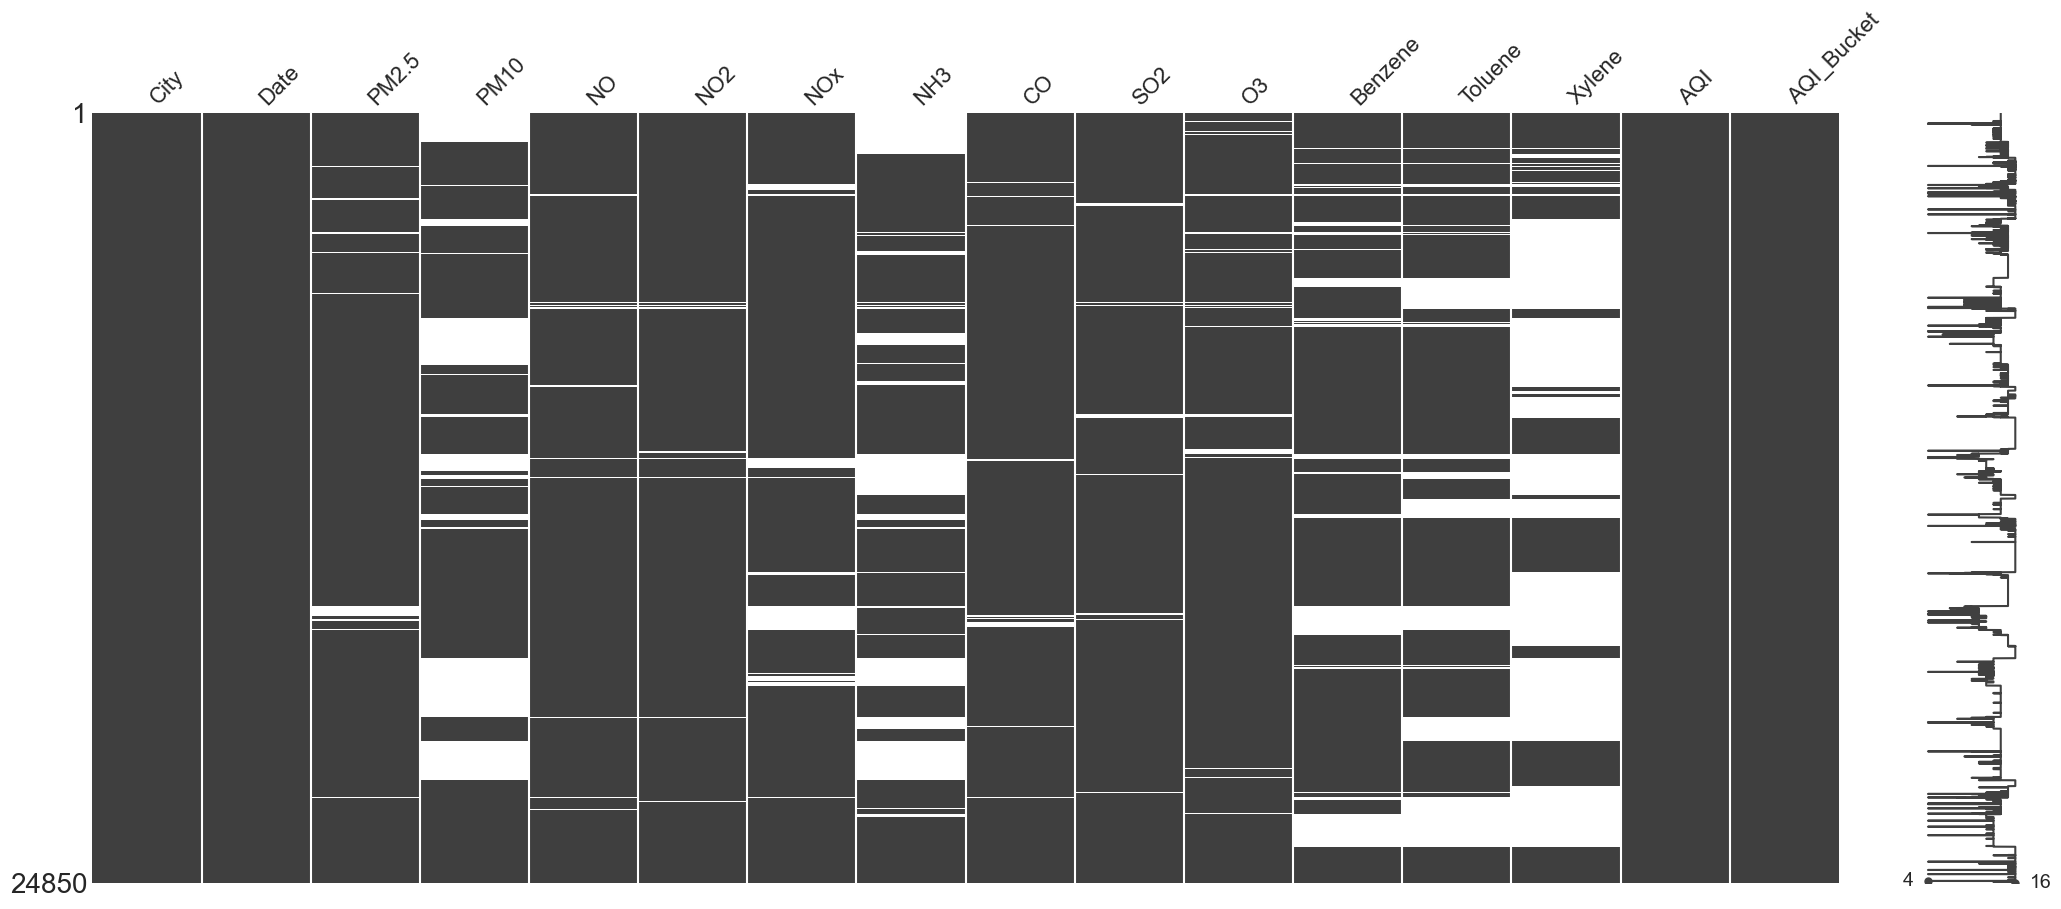

In [386]:
msno.matrix(df)

#### Missing Values Heatmap

<Axes: >

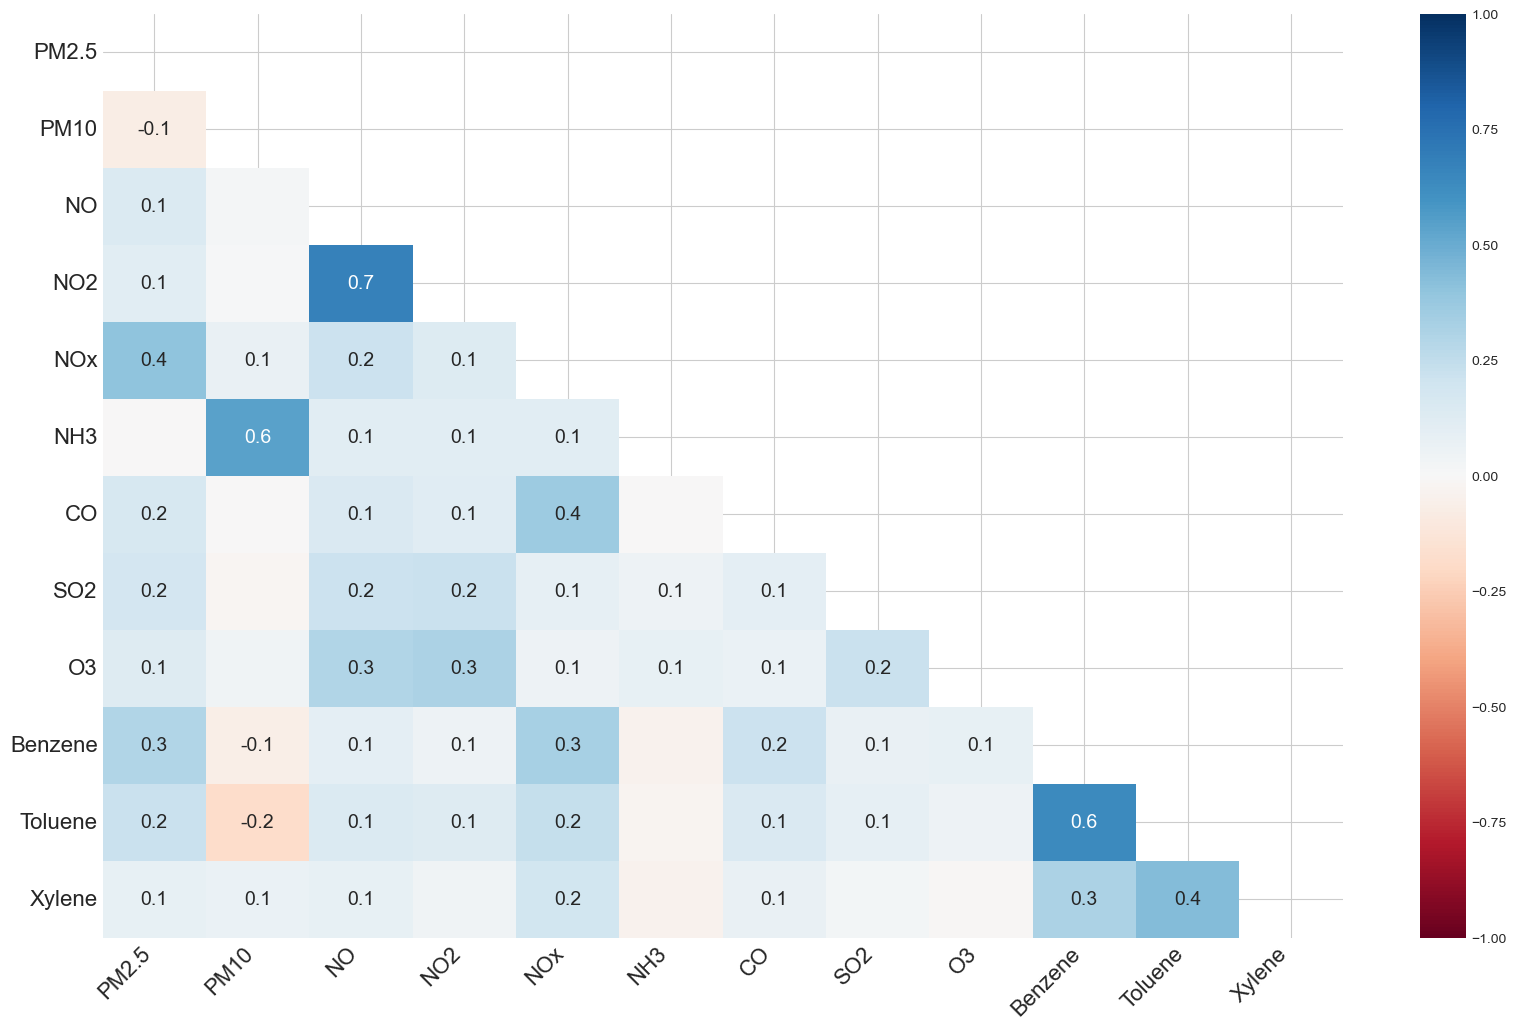

In [387]:
msno.heatmap(df)

In [388]:
city_list = list(df['City'].unique())
column_list = list(df.columns)
significant_df = pd.DataFrame(index=city_list, columns=column_list)
significant_df = significant_df.drop(columns=['City','Date','AQI','AQI_Bucket'])

#### We run a function to check significance of each feature with respect to its city

In [389]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns


city_list = list(df['City'].unique())
column_list = list(df.columns)
grouped_df = df.groupby('City')
category_dfs = {name: group for name, group in grouped_df}

for i in city_list:
    city_df = category_dfs[i]
    iter = missing_values_table(city_df)
    print(f'Missing Values Table for {i}:\n{iter}')
    missing_value_table_index_list = list(iter.index)

    useless_columns=[]
    for k in range(len(iter['% of Total Values'])):
        if iter['% of Total Values'][k]==100:
            useless_columns.append(iter.index[k])

    if useless_columns:
        for l in useless_columns:
            city_df = city_df.drop(columns=[l])
            significant_df[l][i]='No'
    else:
        pass

    for j in missing_value_table_index_list:
        if j not in useless_columns:
            city_column_df = city_df.dropna(subset=[j])
            city_column_df = city_column_df.drop(columns=['City', 'Date', 'AQI_Bucket'])
            city_column_df = city_column_df.fillna(0)

            X = city_column_df.drop(columns=['AQI'])
            Y = city_column_df['AQI']

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

            # Create a linear regression model
            model = LinearRegression()

            # Fit the model on the training data
            model.fit(X_train, y_train)

            X_train_with_const = sm.add_constant(X_train)

            # Fit a linear regression model using statsmodels
            model_statsmodels = sm.OLS(y_train, X_train_with_const).fit()

            #Perform the Hypothesis Test
            # Define the hypothesis matrix
            hypothesis_matrix = j+' = 0'

            # Perform the Wald test
            wald_test_result = model_statsmodels.wald_test(hypothesis_matrix)
            p_value = wald_test_result.pvalue.item()

            if p_value <= 0.05:
                significant_df[j][i]='Yes'
            else:
                significant_df[j][i]='No'

Your selected dataframe has 16 columns.
There are 12 columns that have missing values.
Missing Values Table for Ahmedabad:
         Missing Values  % of Total Values
NH3                1334            100.000
PM10                937             70.200
O3                   85              6.400
SO2                  40              3.000
Xylene               34              2.500
Benzene              33              2.500
Toluene              33              2.500
NO                    7              0.500
NO2                   7              0.500
CO                    7              0.500
PM2.5                 2              0.100
NOx                   2              0.100
Your selected dataframe has 16 columns.
There are 6 columns that have missing values.
Missing Values Table for Aizawl:
         Missing Values  % of Total Values
Xylene              111            100.000
Benzene              15             13.500
Toluene              15             13.500
O3                    9    

Your selected dataframe has 16 columns.
There are 5 columns that have missing values.
Missing Values Table for Kochi:
         Missing Values  % of Total Values
Benzene             158            100.000
Xylene              158            100.000
NH3                  16             10.100
NO2                   6              3.800
NO                    2              1.300
Your selected dataframe has 16 columns.
There are 3 columns that have missing values.
Missing Values Table for Kolkata:
        Missing Values  % of Total Values
Xylene             360             47.700
SO2                  6              0.800
O3                   1              0.100
Your selected dataframe has 16 columns.
There are 12 columns that have missing values.
Missing Values Table for Lucknow:
         Missing Values  % of Total Values
PM10               1893            100.000
Xylene             1893            100.000
NH3                 888             46.900
NOx                 305             16.100


#### This table shows which feature is significant with respect to their city. If the feature is not missing at all it will not test for significance.

In [390]:
significance_matrix_df = significant_df.fillna('Missing Values not found for the city')
significance_matrix_df

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
Ahmedabad,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,No
Aizawl,Yes,No,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,No,No,No,No
Amaravati,Yes,Yes,No,No,No,No,Yes,Yes,Yes,Yes,No,No
Amritsar,Yes,Yes,No,No,No,No,Yes,No,No,No,No,No
Bengaluru,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,No
Bhopal,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,No,No,No
Brajrajnagar,Yes,No,No,No,No,No,Yes,No,No,No,No,No
Chandigarh,Yes,Missing Values not found for the city,No,No,No,No,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city,Missing Values not found for the city
Chennai,Yes,Yes,No,Yes,No,No,Yes,No,Yes,No,No,No
Coimbatore,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No


In [391]:
significant_df=significant_df.fillna('Yes')
def fill_insignificant(df, significant_matrix):
    for city in city_list:
        y_features = []
        n_features = []

        for i in significant_matrix.columns:
            if significant_matrix[i][city] == 'Yes':
                y_features.append(i)
            elif significant_matrix[i][city] == 'No':
                n_features.append(i)

        df.loc[df['City'] == city, n_features] = df.loc[df['City'] == city, n_features].fillna(0)

        city_data = df[df['City'] == city][['Date'] + y_features].copy()
        city_data.set_index('Date', inplace=True)

        knn_imputer = KNNImputer(n_neighbors=5)

        city_data_interpolated = knn_imputer.fit_transform(city_data)
        df.loc[df['City'] == city, y_features] = city_data_interpolated

    return df

#### Now according to the significance we fill the data, if the feature is significant for the city we run KNN imputation for the city specific data. Otherwise we fill the values with zero.

In [392]:
df = fill_insignificant(df, significant_df)
df

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
28,Ahmedabad,2015-01-29,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140,209.000,Poor
29,Ahmedabad,2015-01-30,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810,328.000,Very Poor
30,Ahmedabad,2015-01-31,94.520,0.000,24.390,32.660,52.610,0.000,24.390,67.390,111.330,0.240,0.010,7.670,514.000,Severe
31,Ahmedabad,2015-02-01,135.990,0.000,43.480,42.080,84.570,0.000,43.480,75.230,102.700,0.400,0.040,25.870,782.000,Severe
32,Ahmedabad,2015-02-02,178.330,0.000,54.560,35.310,72.800,0.000,54.560,55.040,107.380,0.460,0.060,35.610,914.000,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000,Good
29527,Visakhapatnam,2020-06-28,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000,Satisfactory
29528,Visakhapatnam,2020-06-29,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000,Satisfactory
29529,Visakhapatnam,2020-06-30,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000,Satisfactory


In [393]:
#This dataframe has been provided for Exploratory Data Analysis
df.to_csv('df_for_eda.csv', index=False)

#### The above dataframe has been provided for Exploratory Data Analysis

### 3f. Outlier Handling - Numerical Columns

#### We check the percentage of outliers of every feature column, considering that the data that lies outside of 3 Standard Deviations from the mean is an outlier.


In [394]:
# Function to calculate the percentage of outliers
def percentage_of_outliers(column):

    lower_bound = column.mean() - 3*column.std()
    upper_bound = column.mean() + 3*column.std()

    outliers = column[(column < lower_bound) | (column > upper_bound)]
    non_zero_count = (column != 0).sum()
    percentage = len(outliers) / non_zero_count * 100

    return percentage

In [395]:
numerical_columns_df = df.drop(columns=['City','Date','AQI_Bucket','AQI'])
outlier_df = pd.DataFrame(index=list(numerical_columns_df.columns), columns=['Percentage of Outliers'])

for i in range(len(outlier_df.index)):
    per = percentage_of_outliers(df[outlier_df.index[i]])
    outlier_df['Percentage of Outliers'][i]=per

outlier_df

,Percentage of Outliers
PM2.5,2.069
PM10,2.018
NO,2.457
NO2,1.819
NOx,2.368
NH3,1.888
CO,2.128
SO2,2.366
O3,1.316
Benzene,0.454


#### Now we truncate the outliers from the data to check if the model performs better.


In [396]:
def truncate_numerical_column(df, numerical_column):
    # Calculate the threshold values based on percentile
    lower_threshold = df[numerical_column].mean() - 3*df[numerical_column].std()
    upper_threshold = df[numerical_column].mean() + 3*df[numerical_column].std()

    # Truncate extreme values to the specified thresholds
    truncated_column_name = numerical_column + '_truncated'
    df[truncated_column_name] = df[numerical_column].clip(lower=lower_threshold, upper=upper_threshold)

    return df

In [397]:
df_with_outliers = df.copy()
df_without_outliers = df.copy()

In [398]:
for i in list(numerical_columns_df.columns):
    truncate_numerical_column(df_without_outliers, i)

#### Truncated Data without outliers

In [399]:
df_without_outliers=df_without_outliers.drop(columns=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene'])
column_name_mapping = {'PM2.5_truncated': 'PM2.5', 'PM10_truncated': 'PM10', 'NO_truncated': 'NO', 'NO2_truncated': 'NO2', 'NOx_truncated': 'NOx', 'NH3_truncated': 'NH3', 'CO_truncated': 'CO', 'SO2_truncated': 'SO2', 'O3_truncated': 'O3', 'Benzene_truncated': 'Benzene', 'Toluene_truncated': 'Toluene', 'Xylene_truncated': 'Xylene'}
df_without_outliers.rename(columns=column_name_mapping, inplace=True)
df_without_outliers

,City,Date,AQI,AQI_Bucket,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
28,Ahmedabad,2015-01-29,209.000,Poor,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140
29,Ahmedabad,2015-01-30,328.000,Very Poor,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810
30,Ahmedabad,2015-01-31,514.000,Severe,94.520,0.000,24.390,32.660,52.610,0.000,23.384,66.851,100.202,0.240,0.010,7.670
31,Ahmedabad,2015-02-01,782.000,Severe,135.990,0.000,43.480,42.080,84.570,0.000,23.384,66.851,100.202,0.400,0.040,18.386
32,Ahmedabad,2015-02-02,914.000,Severe,178.330,0.000,54.560,35.310,72.800,0.000,23.384,55.040,100.202,0.460,0.060,18.386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,41.000,Good,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730
29527,Visakhapatnam,2020-06-28,70.000,Satisfactory,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380
29528,Visakhapatnam,2020-06-29,68.000,Satisfactory,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000
29529,Visakhapatnam,2020-06-30,54.000,Satisfactory,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000


#### Comparing the R-Squared of a Linear Regression model with and without outliers

In [400]:
#Dataset with outliers
columns = ['City', 'Date', 'AQI_Bucket']
df_with_outliers = df_with_outliers.drop(columns, axis=1)

X=df_with_outliers.drop(columns = ['AQI'])
Y=df_with_outliers['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
X_train

model.fit(X_train, y_train)
X_train_with_const = sm.add_constant(X_train)
model_statsmodels = sm.OLS(y_train, X_train_with_const).fit()

print(model_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     9542.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:53:12   Log-Likelihood:            -1.0773e+05
No. Observations:               19880   AIC:                         2.155e+05
Df Residuals:                   19867   BIC:                         2.156e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3681      0.889     19.542      0.0

In [401]:
#Dataset with outliers
columns = ['City', 'Date', 'AQI_Bucket']
df_without_outliers = df_without_outliers.drop(columns, axis=1)

X=df_without_outliers.drop(columns = ['AQI'])
Y=df_without_outliers['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
X_train

model.fit(X_train, y_train)
X_train_with_const = sm.add_constant(X_train)
model_statsmodels = sm.OLS(y_train, X_train_with_const).fit()

print(model_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     6484.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:53:12   Log-Likelihood:            -1.1090e+05
No. Observations:               19880   AIC:                         2.218e+05
Df Residuals:                   19867   BIC:                         2.219e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9069      1.120      0.810      0.4

#### We see that the adjusted R-squared value for the data with the outliers (0.852) is higher than the data without the outliers (0.796). Hence, we do not remove the outliers from the numerical columns. As the data with outliers performs better, we go ahead with the dataset that has outliers

## 4. Seasonality Check

In [402]:
df

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
28,Ahmedabad,2015-01-29,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140,209.000,Poor
29,Ahmedabad,2015-01-30,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810,328.000,Very Poor
30,Ahmedabad,2015-01-31,94.520,0.000,24.390,32.660,52.610,0.000,24.390,67.390,111.330,0.240,0.010,7.670,514.000,Severe
31,Ahmedabad,2015-02-01,135.990,0.000,43.480,42.080,84.570,0.000,43.480,75.230,102.700,0.400,0.040,25.870,782.000,Severe
32,Ahmedabad,2015-02-02,178.330,0.000,54.560,35.310,72.800,0.000,54.560,55.040,107.380,0.460,0.060,35.610,914.000,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000,Good
29527,Visakhapatnam,2020-06-28,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000,Satisfactory
29528,Visakhapatnam,2020-06-29,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000,Satisfactory
29529,Visakhapatnam,2020-06-30,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000,Satisfactory


In [403]:
city_day = df.copy()

In [404]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24850 entries, 28 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        24850 non-null  object 
 1   Date        24850 non-null  object 
 2   PM2.5       24850 non-null  float64
 3   PM10        24850 non-null  float64
 4   NO          24850 non-null  float64
 5   NO2         24850 non-null  float64
 6   NOx         24850 non-null  float64
 7   NH3         24850 non-null  float64
 8   CO          24850 non-null  float64
 9   SO2         24850 non-null  float64
 10  O3          24850 non-null  float64
 11  Benzene     24850 non-null  float64
 12  Toluene     24850 non-null  float64
 13  Xylene      24850 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.2+ MB


In [405]:
city_day.Date = city_day.Date.apply(lambda x : dt.datetime.strptime(x, '%Y-%m-%d'))
city_day = city_day.sort_values(by = 'Date')

city_day['Year_Month'] = city_day.Date.apply(lambda x : x.strftime('%Y-%m'))

new = city_day.groupby(['Year_Month']).sum().reset_index()
features = ['AQI','PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2','O3', 'Benzene', 'Toluene', 'Xylene']

### We plot the values of every feature aggregating over a month, and we see a clear seasonality trend over the years 2015-2020

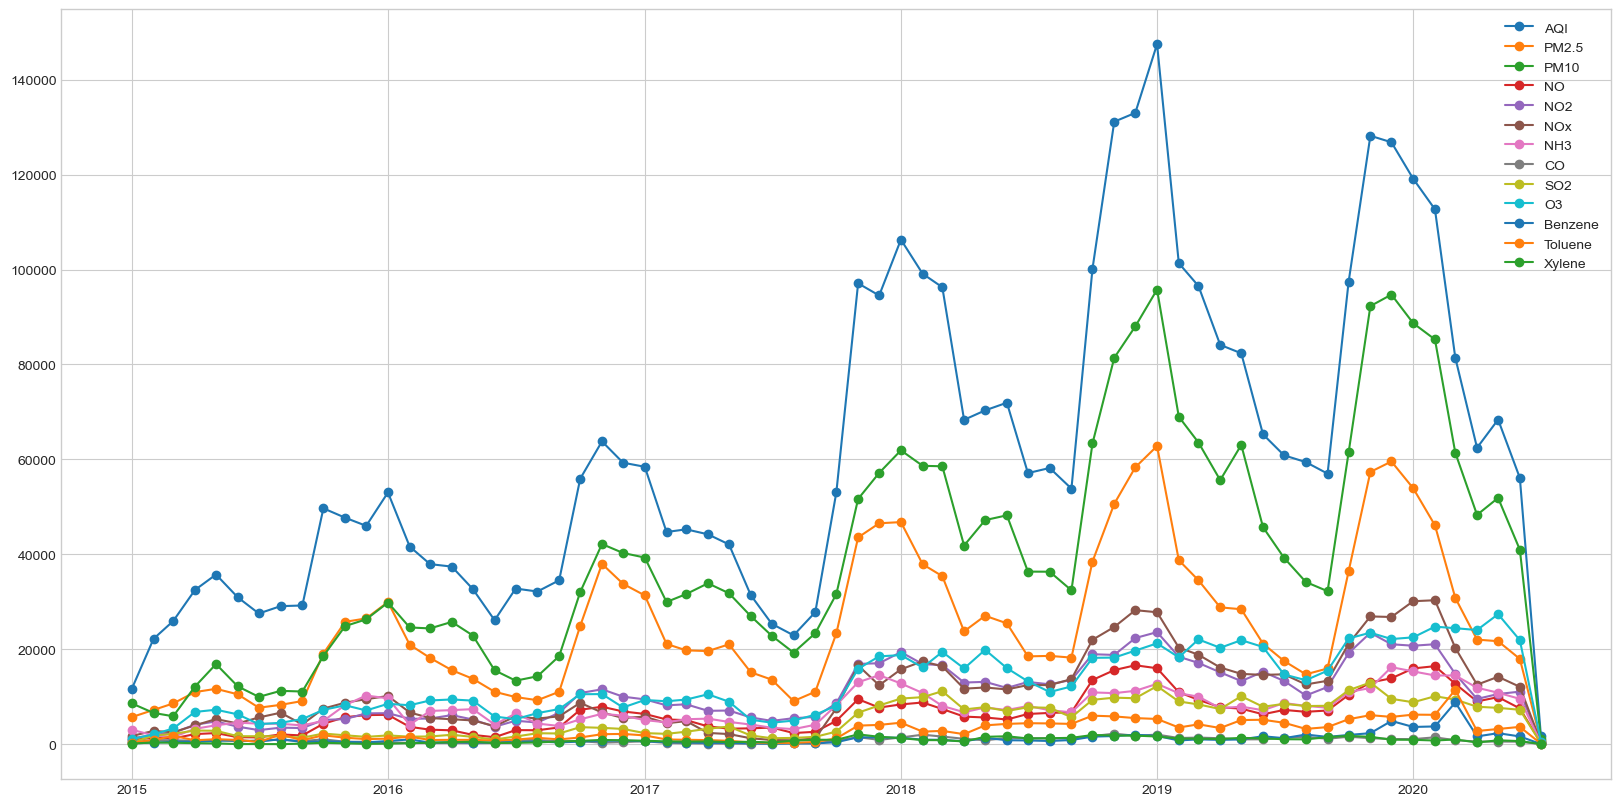

In [406]:
plt.style.use('seaborn-whitegrid')
fig, ax_ = plt.subplots(figsize=(20, 10))

# Assuming 'Year_Month' is a string in the format 'YYYY-MM', convert it to datetime
new['Year_Month'] = pd.to_datetime(new['Year_Month'])

for col in features:
    x = new['Year_Month']
    y = new[col]

    ax_.plot_date(x, y, label=col, linestyle="-")

ax_.legend()

plt.show()

### Taking a closer look for a year and over the months we can see how the pollution level drops from May to September every year. This could be because of the rain and monsoon season.

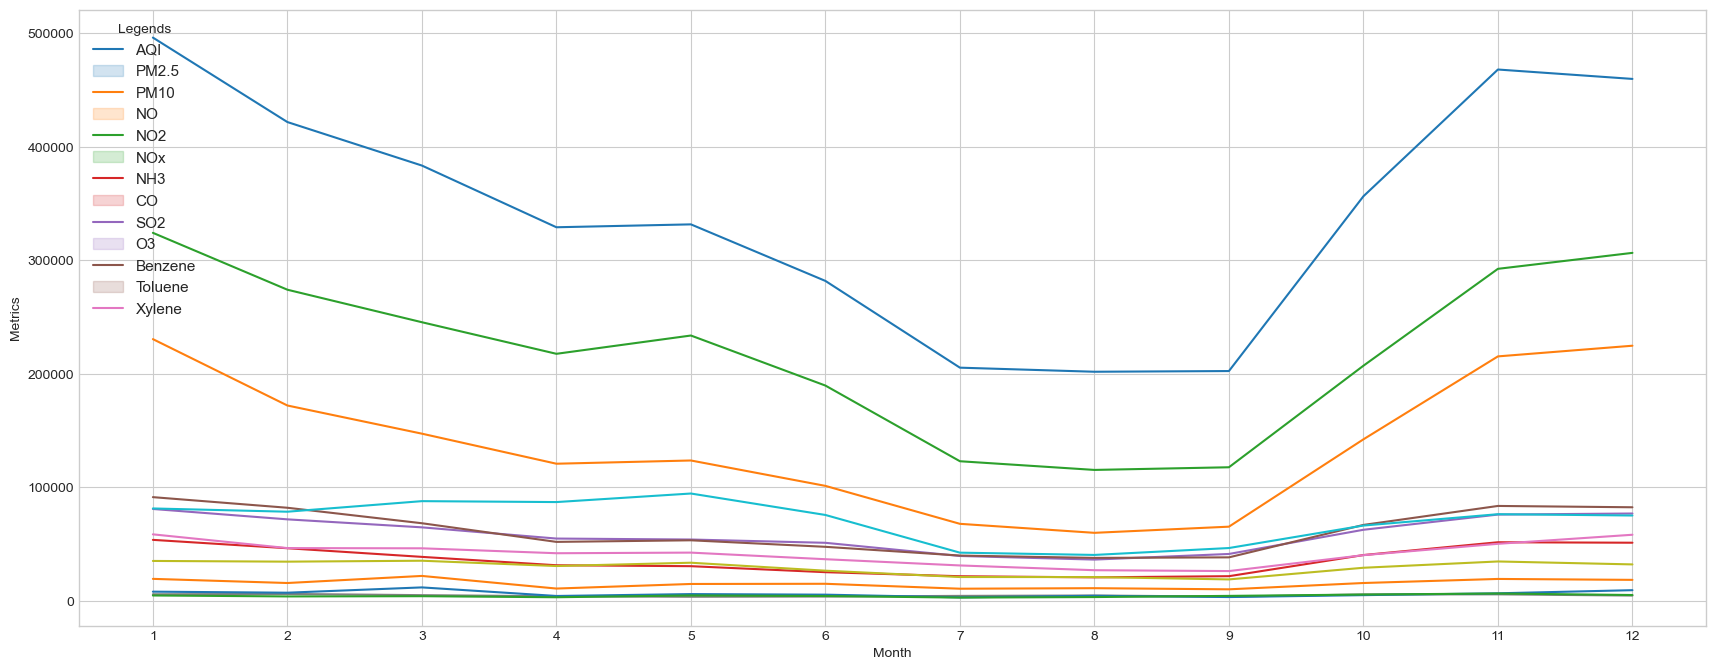

In [407]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

city_day['Month'] = city_day.Date.dt.month
city_day['Year'] = city_day.Date.dt.year

index = 'Month'
new = city_day.groupby([index]).sum().reset_index()

plt.style.use('seaborn-whitegrid')
fig, ax_ = plt.subplots(figsize=(21, 8))

for i, col in enumerate(features):
    x = new[index]
    y = new[col]
    sns.lineplot(x=x, y=y, label=col)  # Correct usage of sns.lineplot

ax_.set(xlabel='Month', ylabel='Metrics')
ax_.set_xticks(new[index])
ax_.set_xticklabels(new[index])
leg = ax_.legend(title='Legends', loc='upper left', labels=features, fontsize=11)

plt.show()

In [408]:
df_backup = df.copy
df_1hot = df.copy()

### Now that we have observed a monthly seasonality, we will investigate the effect of including a ”Month” column in the data set. We will be including a ”Month” column in the data set by extracting the months from the ”Date” column. As the ”Month” data is not ordinal, we will have to one-hot encode it.

In [409]:
df_1hot['Date'] = pd.to_datetime(df_1hot['Date'])
df_1hot['Month'] = df_1hot['Date'].dt.month_name()
month_dummies = pd.get_dummies(df_1hot['Month'])
df_1hot = pd.concat([df_1hot, month_dummies], axis=1)
df_1hot = df_1hot.drop('Month', axis=1)
display(df_1hot)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,April,August,December,February,January,July,June,March,May,November,October,September
28,Ahmedabad,2015-01-29,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140,209.000,Poor,0,0,0,0,1,0,0,0,0,0,0,0
29,Ahmedabad,2015-01-30,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810,328.000,Very Poor,0,0,0,0,1,0,0,0,0,0,0,0
30,Ahmedabad,2015-01-31,94.520,0.000,24.390,32.660,52.610,0.000,24.390,67.390,111.330,0.240,0.010,7.670,514.000,Severe,0,0,0,0,1,0,0,0,0,0,0,0
31,Ahmedabad,2015-02-01,135.990,0.000,43.480,42.080,84.570,0.000,43.480,75.230,102.700,0.400,0.040,25.870,782.000,Severe,0,0,0,1,0,0,0,0,0,0,0,0
32,Ahmedabad,2015-02-02,178.330,0.000,54.560,35.310,72.800,0.000,54.560,55.040,107.380,0.460,0.060,35.610,914.000,Severe,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,Visakhapatnam,2020-06-27,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000,Good,0,0,0,0,0,0,1,0,0,0,0,0
29527,Visakhapatnam,2020-06-28,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000,Satisfactory,0,0,0,0,0,0,1,0,0,0,0,0
29528,Visakhapatnam,2020-06-29,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000,Satisfactory,0,0,0,0,0,0,1,0,0,0,0,0
29529,Visakhapatnam,2020-06-30,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000,Satisfactory,0,0,0,0,0,0,1,0,0,0,0,0


### We will compare the adjusted R-squared of the data set without the ”Month” column and the One-Hot encoded data with the months.

In [410]:
columns = ['City', 'Date', 'AQI_Bucket']
df = df.drop(columns, axis=1)

X=df.drop(columns = ['AQI'])
Y=df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
X_train

model.fit(X_train, y_train)
X_train_with_const = sm.add_constant(X_train)
model_statsmodels = sm.OLS(y_train, X_train_with_const).fit()

In [411]:
print(model_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     9542.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:53:13   Log-Likelihood:            -1.0773e+05
No. Observations:               19880   AIC:                         2.155e+05
Df Residuals:                   19867   BIC:                         2.156e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3681      0.889     19.542      0.0

In [412]:
columns = ['City', 'Date', 'AQI_Bucket']
df_1hot = df_1hot.drop(columns, axis=1)

X_1hot=df_1hot.drop(columns = ['AQI'])
Y_1hot=df_1hot['AQI']

X_train_1hot, X_test_1hot, y_train_1hot, y_test_1hot = train_test_split(X_1hot, Y_1hot, test_size=0.2, random_state=42)
model_1hot = LinearRegression()
model_1hot.fit(X_train_1hot, y_train_1hot)
X_train_with_const_1hot = sm.add_constant(X_train_1hot)
model_statsmodels_1hot = sm.OLS(y_train_1hot, X_train_with_const_1hot).fit()

In [413]:
print(model_statsmodels_1hot.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     5000.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:53:13   Log-Likelihood:            -1.0769e+05
No. Observations:               19880   AIC:                         2.154e+05
Df Residuals:                   19856   BIC:                         2.156e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.8903      0.884     20.238      0.0

### From the images, we can see that both models have similar adjusted R-squared values (0.852 and 0.853). As it is not a significant increase in the value, we stick to the data without the ”Month” column.

## 5. Checking for Model Accuracy and Cross Validation

### We check model accuracy by testing on a X Test Dataset and calculating R2 Score and Mean Square Error.

In [414]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 3702.7705158754434
R-squared (R2): 0.7977845974175743


### We further check model accuracy by using 5 Fold Cross Validation on X parameters Dataset and calculating it's R2 Score and Mean Square Error.

In [415]:
# Define a custom scoring function for cross-validation based on R-squared
scorer = make_scorer(r2_score)

# Perform cross-validation
cv_scores = cross_val_score(model, X, Y, cv=5, scoring=scorer)

# Print the cross-validation scores
print("Cross-Validation R-squared Scores:")
print(cv_scores)

# Print the average R-squared score
print(f"Average R-squared Score: {np.mean(cv_scores)}")

Cross-Validation R-squared Scores:
[0.70177679 0.84856842 0.77124618 0.66800351 0.83111987]
Average R-squared Score: 0.7641429510303689


### Similarly we check model accuracy by using 5-Fold Cross Validation on X parameters Dataset and calculating R2 Score and Mean Square Error.

Cross-validated R-squared Score: 0.850889908830847


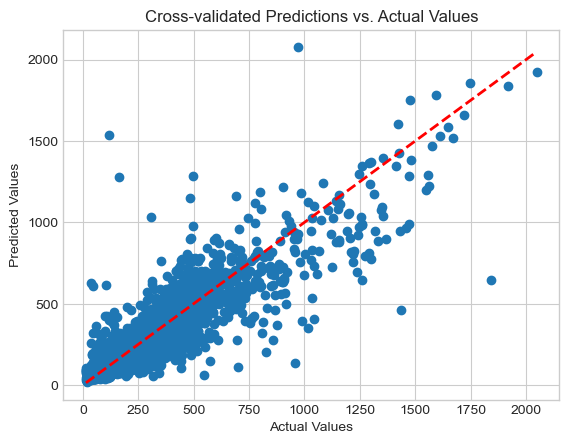

In [416]:
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5)

# Evaluate the R-squared score on the training set
r2_cv = r2_score(y_train, y_pred_cv)
print(f"Cross-validated R-squared Score: {r2_cv}")

# Plot the predicted vs. actual values
plt.scatter(y_train, y_pred_cv)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Cross-validated Predictions vs. Actual Values')
plt.show()

## 6. Checking for Model Assumptions

### Residuals v/s Fitted Values plot – To check if the residuals have a constant variance across all levels of independent variables, and they are scattered with a mean around 0.

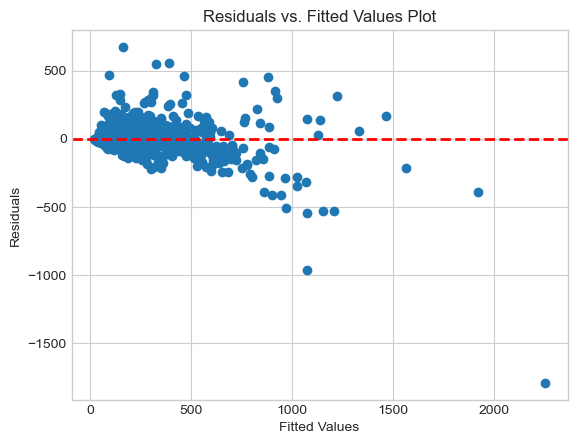

In [417]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs. fitted values
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()

### Normal Q-Q Plot – To check how close the residuals are to following a normal distribution.

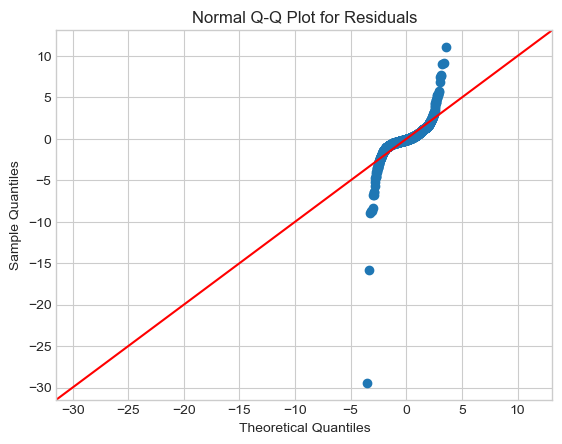

In [418]:
# Create a normal Q-Q plot for residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal Q-Q Plot for Residuals')
plt.show()

#### We see that, in the Normal Q-Q Plot, the plot is distorted showing a Fat Tail distribution, and the plot does not trace the normal line with major deviations at the ends of the plot. Additionally, the residuals also fail the Shapiro Wilk test.

### As a next step, we will try to check if the distortion might be because of the existence of observations in the dataset that might be outliers.

In [419]:
from statsmodels.stats.outliers_influence import OLSInfluence

X = df.drop(columns=['AQI'])
y = df['AQI']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Get the Cook's distance and other influence statistics
influence = OLSInfluence(model)
cooks_distance = influence.cooks_distance
cooks_distance_values = cooks_distance[0]

### Cook's Distance vs. Half Normal Quantiles Plot - plot is particularly useful in identifying influential points that might have a significant impact on the model's fit and performance.

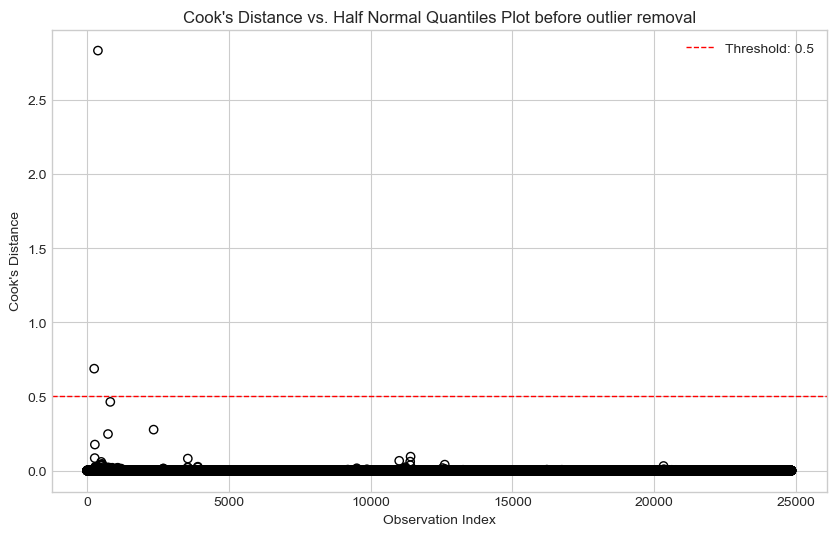

In [420]:
# Create Cook's Distance vs. Half Normal Quantiles plot
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(cooks_distance_values)), cooks_distance_values, edgecolors='k', facecolors='none')
plt.title("Cook's Distance vs. Half Normal Quantiles Plot before outlier removal")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='Threshold: 0.5')
plt.legend()
plt.show()

#### We see that there are just two points outside the threshold, and most of the points are within the thereshold. 

#### Hence,we can deduce the following:

#### 1. The fact that most points are within the threshold suggests that the overall model is relatively stable, and no single observation disproportionately affects the model parameters.

#### 2. If the majority of points fall within an acceptable range, it indicates that the model adequately captures the data patterns, and influential outliers are not unduly influencing the results.

#### 3. In such a scenario, you can interpret the plot as reassuring evidence of the robustness of your regression model. The absence of outliers or influential points allows for greater confidence in the estimated coefficients.

### Residuals v/s Leverage Plot – To assess the influence of individual data points on the estimated coefficients of the model.

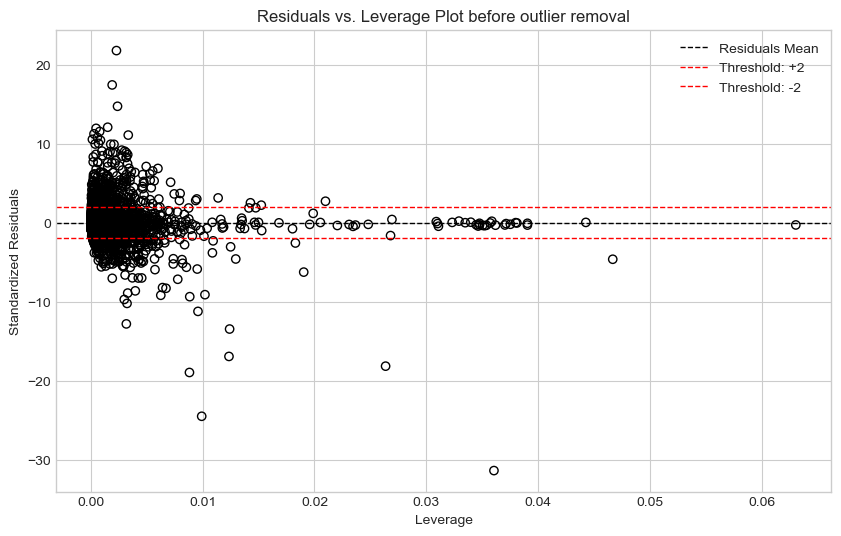

In [421]:
leverage = influence.hat_matrix_diag
standardized_residuals = influence.resid_studentized_internal

# Create Residuals vs. Leverage plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage, standardized_residuals, edgecolors='k', facecolors='none')
plt.title('Residuals vs. Leverage Plot before outlier removal')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Residuals Mean')
plt.axhline(y=2, color='red', linestyle='--', linewidth=1, label='Threshold: +2')
plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='Threshold: -2')
plt.legend()
plt.show()

#### We can see that the there are no observations in the top right or bottom right corner, as these would indicate outliers which have a significant impact on the model, which would need to be investigated individually. Most of the observations with high residuals, have low leverages. So, we can predict that getting rid fo them would have inversely affect the performance of the model.

### We perform the Shapiro-Wilk test to check if the residuals are normally distributed. As the hypothesis is rejected we conclude that the residuals are not normally distributed.

In [422]:
# Perform Shapiro-Wilk test on residuals
stat, p_value = stats.shapiro(residuals)

# Print the test statistic and p-value
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Check the null hypothesis (H0)
if p_value > 0.05:
    print("Residuals are normally distributed (fail to reject H0)")
else:
    print("Residuals are not normally distributed (reject H0)")


Shapiro-Wilk Test Statistic: 0.6328169107437134
P-value: 0.0
Residuals are not normally distributed (reject H0)


### We also perform the Durbin-Watson test for checking the autocorrelation in the residuals. We see that the autocorrelation is likely minimal

In [423]:
# Perform Durbin-Watson test for autocorrelation
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)

# Print the Durbin-Watson statistic
print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')

# Interpret the results
if durbin_watson_statistic < 1.5:
    print('Positive autocorrelation may be present.')
elif durbin_watson_statistic > 2.5:
    print('Negative autocorrelation may be present.')
else:
    print('Autocorrelation is likely minimal.')

Durbin-Watson Statistic: 1.9734415147931488
Autocorrelation is likely minimal.


## 7. Outlier Detection and Handling - Observations

In [424]:
df

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
28,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140,209.000
29,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810,328.000
30,94.520,0.000,24.390,32.660,52.610,0.000,24.390,67.390,111.330,0.240,0.010,7.670,514.000
31,135.990,0.000,43.480,42.080,84.570,0.000,43.480,75.230,102.700,0.400,0.040,25.870,782.000
32,178.330,0.000,54.560,35.310,72.800,0.000,54.560,55.040,107.380,0.460,0.060,35.610,914.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000
29527,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000
29528,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000
29529,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000


### We run a code to calculate the Cook's Distance for every observation. The observations with the distance greater than the threshold is considered an outlier. 

### Threshold  = 4 / (Length of the Dataset - Number of Predictor Variables - 1)


### We also calculate the Leverage scores for every observation.

In [425]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

X = df.drop(columns=['AQI'])
y = df['AQI']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Get the Cook's distance and other influence statistics
influence = OLSInfluence(model)
cooks_distance = influence.cooks_distance
cooks_distance_values = cooks_distance[0]
print("Cook Distance for every observation")
display(cooks_distance_values.head(10))

# Leverage score for each observation
leverage_influence = model.get_influence()
leverage_values = leverage_influence.hat_matrix_diag
leverage_matrix = pd.DataFrame({'Leverage': leverage_values})
display(leverage_matrix.head(10))

# Set a threshold to identify influential observations
threshold = 4 / (len(y) - 12 - 1)
influential_obs = cooks_distance_values > threshold

# Print or do something with the influential observations
print("Influential observations:", display(df[influential_obs]))
df_without_outliers = df[~influential_obs].copy()

# Print or do something with the new dataset without outliers
print("Original dataset shape:", df.shape)
print("Dataset shape without outliers:", df_without_outliers.shape)

Cook Distance for every observation


28   0.000
29   0.000
30   0.000
31   0.000
32   0.000
33   0.000
34   0.000
35   0.000
36   0.000
37   0.000
dtype: float64

,Leverage
0,0.001
1,0.001
2,0.002
3,0.004
4,0.006
5,0.002
6,0.000
7,0.000
8,0.001
9,0.001


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
33,139.700,0.000,30.610,28.400,56.730,0.000,30.610,33.790,73.600,0.170,0.030,11.870,660.000
41,66.520,0.000,6.340,23.800,28.240,0.000,6.340,66.580,53.140,9.700,9.630,16.490,388.000
46,99.700,0.000,19.850,28.100,47.310,0.000,19.850,73.230,30.570,10.280,31.250,4.000,536.000
47,80.610,0.000,15.960,21.040,35.670,0.000,15.960,54.700,36.200,8.140,18.750,2.520,479.000
48,100.790,0.000,16.240,25.930,41.910,0.000,16.240,43.110,37.430,10.000,32.410,4.040,592.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26743,83.180,263.040,215.420,33.720,195.690,38.130,1.020,44.800,23.000,0.000,0.000,0.000,280.000
26795,230.160,324.920,11.550,8.670,20.200,1.840,1.350,10.610,21.400,0.000,0.000,0.000,245.000
26798,354.440,347.580,17.180,4.560,16.380,1.820,1.710,16.280,23.180,0.000,0.000,0.000,289.000
28174,89.960,94.000,37.460,88.720,71.160,12.630,1.340,17.600,14.470,9.450,14.820,17.370,110.000


Influential observations: None
Original dataset shape: (24850, 13)
Dataset shape without outliers: (23602, 13)


### We filter the dataset and remove the outliers.

In [426]:
df_without_outliers

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
28,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140,209.000
29,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810,328.000
30,94.520,0.000,24.390,32.660,52.610,0.000,24.390,67.390,111.330,0.240,0.010,7.670,514.000
31,135.990,0.000,43.480,42.080,84.570,0.000,43.480,75.230,102.700,0.400,0.040,25.870,782.000
32,178.330,0.000,54.560,35.310,72.800,0.000,54.560,55.040,107.380,0.460,0.060,35.610,914.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000
29527,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000
29528,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000
29529,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000


### Now we run an OLS model on the data after removing the outliers to measure the performance.

In [427]:
# OLS Without Outliers

X=df_without_outliers.drop(columns = ['AQI'])
Y=df_without_outliers['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
X_train

model.fit(X_train, y_train)
X_train_with_const = sm.add_constant(X_train)
model_statsmodels = sm.OLS(y_train, X_train_with_const).fit()
print(model_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 1.593e+04
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:53:14   Log-Likelihood:                -91648.
No. Observations:               18881   AIC:                         1.833e+05
Df Residuals:                   18868   BIC:                         1.834e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1811      0.542     24.331      0.0

### As we can see that, the Adjusted R-Squared value of the dataset without outliers is better than that for the dataset with outliers. Therefore, now we will use the dataset without outliers (df_without_outliers)

### We again plot the Cook's Distances against the Half Normal Quantiles and the Residuals against the Leverage scores to check the change in the data after removing outliers.

In [428]:
X = df_without_outliers.drop(columns=['AQI'])
y = df_without_outliers['AQI']

X = sm.add_constant(X)
model_outlier = sm.OLS(y, X).fit()

# Get the Cook's distance and other influence statistics
influence = OLSInfluence(model_outlier)
cooks_distance = influence.cooks_distance
cooks_distance_values = cooks_distance[0]

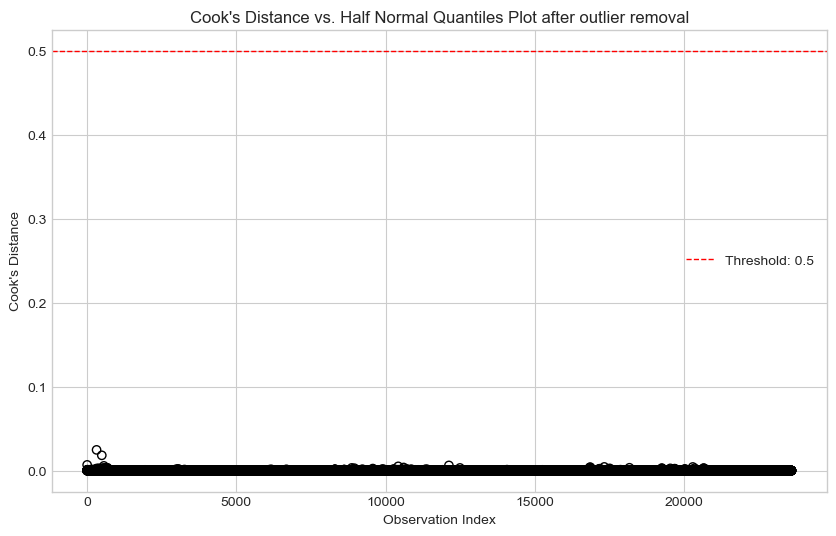

In [429]:
# Create Cook's Distance vs. Half Normal Quantiles plot
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(cooks_distance_values)), cooks_distance_values, edgecolors='k', facecolors='none')
plt.title("Cook's Distance vs. Half Normal Quantiles Plot after outlier removal")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='Threshold: 0.5')
plt.legend()
plt.show()

#### We can see that we have the desired results. All the observations are within the threshold in the Cook's Distance v/s Half Normal Quantile plot

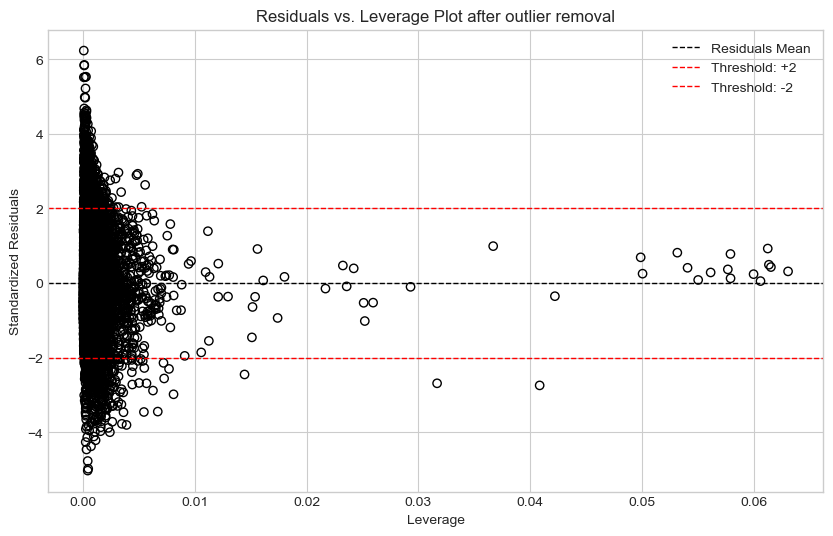

In [430]:
leverage = influence.hat_matrix_diag
standardized_residuals = influence.resid_studentized_internal

# Create Residuals vs. Leverage plot
plt.figure(figsize=(10, 6))
plt.scatter(leverage, standardized_residuals, edgecolors='k', facecolors='none')
plt.title('Residuals vs. Leverage Plot after outlier removal')
plt.xlabel('Leverage')
plt.ylabel('Standardized Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Residuals Mean')
plt.axhline(y=2, color='red', linestyle='--', linewidth=1, label='Threshold: +2')
plt.axhline(y=-2, color='red', linestyle='--', linewidth=1, label='Threshold: -2')
plt.legend()
plt.show()

## 8. Checking for Model Accuracy and Cross Validation - Dataset without outliers

### We check model accuracy by testing on a X Test Dataset and calculating R2 Score and Mean Square Error.

In [431]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 1002.6044482782344
R-squared (R2): 0.9083960564259083


### Similarly we check model accuracy by using 5-Fold Cross Validation on X parameters Dataset and calculating R2 Score and Mean Square Error.

In [432]:
# Define a custom scoring function for cross-validation based on R-squared
scorer = make_scorer(r2_score)

# Perform cross-validation
cv_scores = cross_val_score(model, X, Y, cv=5, scoring=scorer)

# Print the cross-validation scores
print("Cross-Validation R-squared Scores:")
print(cv_scores)

# Print the average R-squared score
print(f"Average R-squared Score: {np.mean(cv_scores)}")

Cross-Validation R-squared Scores:
[0.91903995 0.87689683 0.88771089 0.78940022 0.90097714]
Average R-squared Score: 0.8748050059210477


### Now we plot Cross Validated Predictions against the Actual Values and we can see a change in the graph.

Cross-validated R-squared Score: 0.9100196044934646


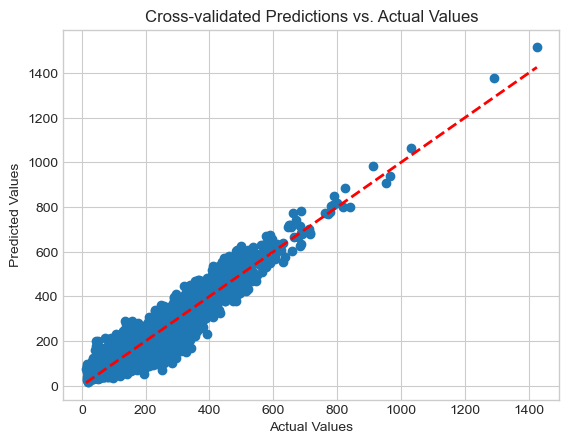

In [433]:
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5)

# Evaluate the R-squared score on the training set
r2_cv = r2_score(y_train, y_pred_cv)
print(f"Cross-validated R-squared Score: {r2_cv}")

# Plot the predicted vs. actual values
plt.scatter(y_train, y_pred_cv)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Cross-validated Predictions vs. Actual Values')
plt.show()

## 9. Checking for Model Assumptions after Outlier Removal

### Residuals v/s Fitted Values plot – To check if the residuals have a constant variance across all levels of independent variables, and they are scattered with a mean around 0.

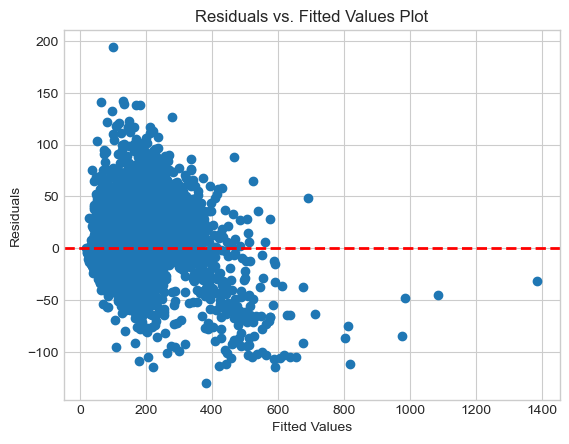

In [434]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs. fitted values
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot')
plt.show()

### Normal Q-Q Plot – To check how close the residuals are to following a normal distribution.

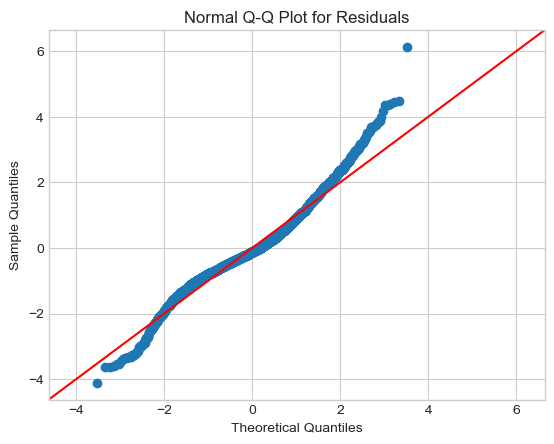

In [435]:
# Create a normal Q-Q plot for residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title('Normal Q-Q Plot for Residuals')
plt.show()

####  We see that even though the residuals still fail the Shapiro-Wilk Normality test, there is a significant improvement in how the the Normal Q-Q Plot traces the normal line, still indicating a Fat Tail distribution.

### We perform the Shapiro-Wilk test to check if the residuals are normally distributed. As the hypothesis is rejected we conclude that the residuals are not normally distributed.

In [436]:
# Perform Shapiro-Wilk test on residuals
stat, p_value = stats.shapiro(residuals)

# Print the test statistic and p-value
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Check the null hypothesis (H0)
if p_value > 0.05:
    print("Residuals are normally distributed (fail to reject H0)")
else:
    print("Residuals are not normally distributed (reject H0)")


Shapiro-Wilk Test Statistic: 0.9633994102478027
P-value: 5.5187806732175555e-33
Residuals are not normally distributed (reject H0)


### We also perform the Durbin-Watson test for checking the autocorrelation in the residuals. We see that the autocorrelation is likely minimal

In [437]:
# Perform Durbin-Watson test for autocorrelation
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)

# Print the Durbin-Watson statistic
print(f'Durbin-Watson Statistic: {durbin_watson_statistic}')

# Interpret the results
if durbin_watson_statistic < 1.5:
    print('Positive autocorrelation may be present.')
elif durbin_watson_statistic > 2.5:
    print('Negative autocorrelation may be present.')
else:
    print('Autocorrelation is likely minimal.')

Durbin-Watson Statistic: 2.0116750646182404
Autocorrelation is likely minimal.


## 10. Performing a transformation as the residuals are still not normally distributed, to improve on the Normal Q-Q plot.

In [438]:
df_without_outliers

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
28,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140,209.000
29,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810,328.000
30,94.520,0.000,24.390,32.660,52.610,0.000,24.390,67.390,111.330,0.240,0.010,7.670,514.000
31,135.990,0.000,43.480,42.080,84.570,0.000,43.480,75.230,102.700,0.400,0.040,25.870,782.000
32,178.330,0.000,54.560,35.310,72.800,0.000,54.560,55.040,107.380,0.460,0.060,35.610,914.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,41.000
29527,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,70.000
29528,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,68.000
29529,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,54.000


### We perform a log transformation on the y values and plot the Quantile-Quantile plot again to check the normality of the Residuals.

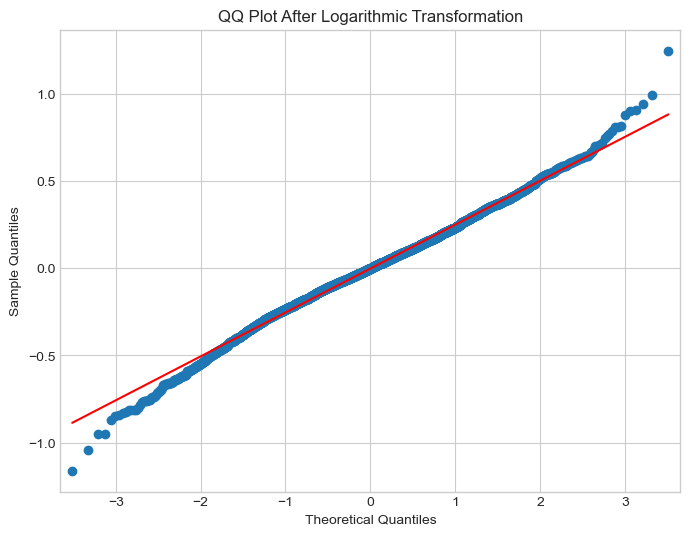

In [439]:
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

X = df_without_outliers.drop('AQI', axis=1)
Y = df_without_outliers['AQI']

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Apply a logarithmic transformation to the response variable
Y_transformed = np.log1p(Y)

#Splitting into test and train data
#X_train, X_test, y_train, y_test = train_test_split(X, Y_transformed, test_size=0.2, random_state=42)

# Fit the OLS model with the transformed response variable
model_transformed = sm.OLS(Y_transformed, X).fit()

# Get the Cook's distance and other influence statistics
influence = OLSInfluence(model_transformed)
cooks_distance = influence.cooks_distance
cooks_distance_values = cooks_distance[0]

# Set a threshold to identify influential observations
threshold = 4 / len(y)
influential_obs = cooks_distance_values > threshold

# Print or do something with the influential observations
# print("Influential observations:", display(data_without_outliers[influential_obs]))
df_without_outliers_log = df_without_outliers[~influential_obs].copy()

X_log = df_without_outliers_log.drop('AQI', axis=1)
Y_log = df_without_outliers_log['AQI']

Y_transformed_log = np.log1p(Y_log)

X_log = sm.add_constant(X_log)

#Splitting into test and train data
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, Y_transformed_log, test_size=0.2, random_state=42)

# Fit the OLS model with the transformed response variable
model_log = LinearRegression()
model_log.fit(X_train_log, y_train_log)
model_transformed_new_log = sm.OLS(y_train_log, X_train_log).fit()

# Make predictions on the test data
y_pred_transformed_log = model_transformed_new_log.predict(X_test_log)

# Calculate residuals
residuals_after = y_test_log - y_pred_transformed_log

# QQ plot after transformation
fig, ax_after = plt.subplots(figsize=(8, 6))
qqplot(residuals_after, line='s', ax=ax_after)
ax_after.set_title('QQ Plot After Logarithmic Transformation')

plt.show()

### We also perform a Box-Cox/Power transformation on the y values and plot the Quantile-Quantile plot again to check the normality of the Residuals.

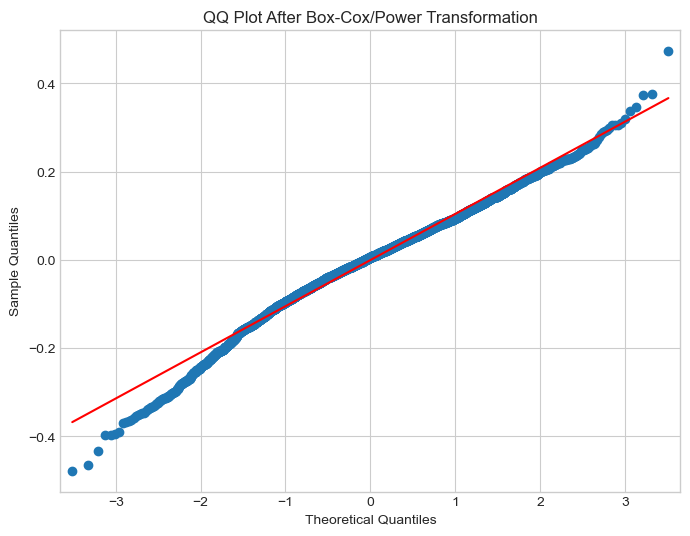

In [440]:
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

X = df_without_outliers.drop('AQI', axis=1)
Y = df_without_outliers['AQI']

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Apply a logarithmic transformation to the response variable
Y_transformed, lambda_value = boxcox(Y)

# Fit the OLS model with the transformed response variable
model_transformed = sm.OLS(Y_transformed, X).fit()

# Get the Cook's distance and other influence statistics
influence = OLSInfluence(model_transformed)
cooks_distance = influence.cooks_distance
cooks_distance_values = cooks_distance[0]

# Set a threshold to identify influential observations
threshold = 4 / len(y)
influential_obs = cooks_distance_values > threshold

# Print or do something with the influential observations
# print("Influential observations:", display(data_without_outliers[influential_obs]))
df_without_outliers_power = df_without_outliers[~influential_obs].copy()

X_power = df_without_outliers_power.drop('AQI', axis=1)
Y_power = df_without_outliers_power['AQI']

Y_transformed_power, lambda_value = boxcox(Y_power)

X_power = sm.add_constant(X_power)

#Splitting into test and train data
X_train_power, X_test_power, y_train_power, y_test_power = train_test_split(X_power, Y_transformed_power, test_size=0.2, random_state=42)

# Fit the OLS model with the transformed response variable
model_transformed_new_power = sm.OLS(y_train_power, X_train_power).fit()

# Make predictions on the test data
y_pred_transformed_power = model_transformed_new_power.predict(X_test_power)

# Calculate residuals
residuals_after = y_test_power - y_pred_transformed_power

# QQ plot after transformation
fig, ax_after = plt.subplots(figsize=(8, 6))
qqplot(residuals_after, line='s', ax=ax_after)
ax_after.set_title('QQ Plot After Box-Cox/Power Transformation')

plt.show()

### We can see that the Normal Q-Q Plot for the residuals after log transformation is better than that for the box-cox/power transformation. So we will use the dataset after log transformation.

The new dataset is --> df_without_outliers_log

In [441]:
AQI_transformed = np.log1p(df_without_outliers_log['AQI'])
df_without_outliers_log['AQI'] = AQI_transformed

In [442]:
df_without_outliers_log

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
28,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.020,0.000,3.140,5.347
29,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.040,0.000,4.810,5.796
35,58.360,0.000,2.600,21.390,23.310,0.000,2.600,32.660,53.540,0.000,0.000,0.000,5.011
36,79.290,0.000,1.160,26.940,26.830,0.000,1.160,67.410,59.300,0.000,0.000,0.000,5.252
37,88.700,0.000,7.290,31.320,37.730,0.000,7.290,80.090,44.760,0.000,0.000,0.000,5.513
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29526,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,2.240,12.070,0.730,3.738
29527,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,0.740,2.210,0.380,4.263
29528,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.010,0.000,4.234
29529,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,0.000,4.007


In [443]:
model_transformed_new_log

In [444]:
print(model_transformed_new_log.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     6620.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:53:17   Log-Likelihood:                -277.34
No. Observations:               17969   AIC:                             580.7
Df Residuals:                   17956   BIC:                             682.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9001      0.005    841.538      0.0

## 11. Checking for Model Accuracy and Cross Validation - Dataset after transformation

### We check model accuracy by testing on a X Test Dataset and calculating R2 Score and Mean Square Error.

In [445]:
# Evaluate the model performance
mse = mean_squared_error(y_test_log, y_pred_transformed_log)
r2 = r2_score(y_test_log, y_pred_transformed_log)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.06330548920874778
R-squared (R2): 0.8123718947320921


### Similarly we check model accuracy by using 5-Fold Cross Validation on X parameters Dataset and calculating R2 Score and Mean Square Error.

In [446]:
# Define a custom scoring function for cross-validation based on R-squared
scorer = make_scorer(r2_score)

# Perform cross-validation
cv_scores = cross_val_score(model_log, X_log, Y_transformed_log, cv=5, scoring=scorer)

# Print the cross-validation scores
print("Cross-Validation R-squared Scores:")
print(cv_scores)

# Print the average R-squared score
print(f"Average R-squared Score: {np.mean(cv_scores)}")

Cross-Validation R-squared Scores:
[0.7744158  0.78302699 0.80414316 0.69704834 0.81818065]
Average R-squared Score: 0.7753629887043699


### Now we plot Cross Validated Predictions against the Actual Values and we can see a change in the graph.

Cross-validated R-squared Score: 0.8154071524097098


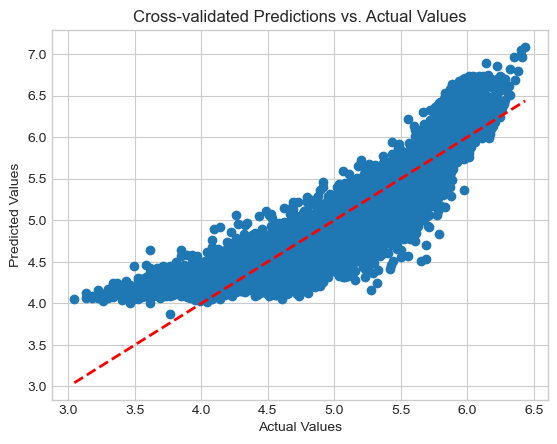

In [447]:
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model_log, X_train_log, y_train_log, cv=5)

# Evaluate the R-squared score on the training set
r2_cv = r2_score(y_train_log, y_pred_cv)
print(f"Cross-validated R-squared Score: {r2_cv}")

# Plot the predicted vs. actual values
plt.scatter(y_train_log, y_pred_cv)
plt.plot([min(y_train_log), max(y_train_log)], [min(y_train_log), max(y_train_log)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Cross-validated Predictions vs. Actual Values')
plt.show()

## 12. Multi-Collinearity Check

### We do this by calculating the Variance Inflation Factor for each feature and calculating its average. As none of the feature has VIF greater than 10 and average VIF is not very greater than 1. We can conclude that there is not Multicollinearity in the data.

In [448]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Separate predictor variables (X) and dependent variable (y)
X = df_without_outliers_log.drop('AQI', axis=1)
y = df_without_outliers_log['AQI']

correlation_matrix = X.corr()

# Add a constant term to the predictor variables
X = sm.add_constant(X)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
average_vif = vif_data['VIF'].mean()

# Display the VIF values
print(vif_data)
print("Average VIF: ", average_vif)

   Variable   VIF
0     const 6.370
1     PM2.5 1.765
2      PM10 1.815
3        NO 2.920
4       NO2 2.078
5       NOx 3.594
6       NH3 1.138
7        CO 1.334
8       SO2 1.314
9        O3 1.207
10  Benzene 1.412
11  Toluene 1.901
12   Xylene 1.276
Average VIF:  2.1633958744276143


#### The VIF values indicate that multicollinearity is relatively low in my model. The average VIF is around 2.16, which is generally considered low to moderate. This means that, on average, the variance of the estimated coefficients is inflated by a factor of 2.16 due to multicollinearity. In particular, all individual VIF values are below 5, with the const variable having a slightly higher VIF of 6.37. It's worth noting that a higher VIF for the constant term is common and generally not a concern. The highest individual VIF is for the NOx variable at 3.59, which is still below the commonly used threshold of 5. Overall, these VIF values suggest that multicollinearity is not a severe issue in my model. As I evaluate my regression model, I'll also consider other diagnostic measures and contextual factors. If my model is providing stable and meaningful results, the current level of multicollinearity appears to be acceptable. It's important to remember that these are guidelines, and the interpretation of VIF values depends on the specific context of my analysis.

In [449]:
correlation_matrix

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
PM2.5,1.000,0.567,0.415,0.400,0.380,0.202,0.093,0.172,0.182,0.071,0.174,0.237
PM10,0.567,1.000,0.418,0.314,0.419,0.072,-0.064,0.193,0.170,0.065,0.180,0.306
NO,0.415,0.418,1.000,0.424,0.783,0.132,0.103,0.157,-0.059,0.132,0.178,0.101
NO2,0.400,0.314,0.424,1.000,0.607,0.161,0.210,0.241,0.277,0.148,0.412,0.130
NOx,0.380,0.419,0.783,0.607,1.000,0.139,0.144,0.124,0.056,0.191,0.262,0.081
NH3,0.202,0.072,0.132,0.161,0.139,1.000,-0.058,-0.075,0.066,0.030,0.017,-0.169
CO,0.093,-0.064,0.103,0.210,0.144,-0.058,1.000,0.366,-0.009,0.067,0.302,0.028
SO2,0.172,0.193,0.157,0.241,0.124,-0.075,0.366,1.000,0.165,0.035,0.271,0.103
O3,0.182,0.170,-0.059,0.277,0.056,0.066,-0.009,0.165,1.000,0.011,0.172,0.048
Benzene,0.071,0.065,0.132,0.148,0.191,0.030,0.067,0.035,0.011,1.000,0.506,0.122


Text(0.5, 1.0, 'Correlation Heatmap')

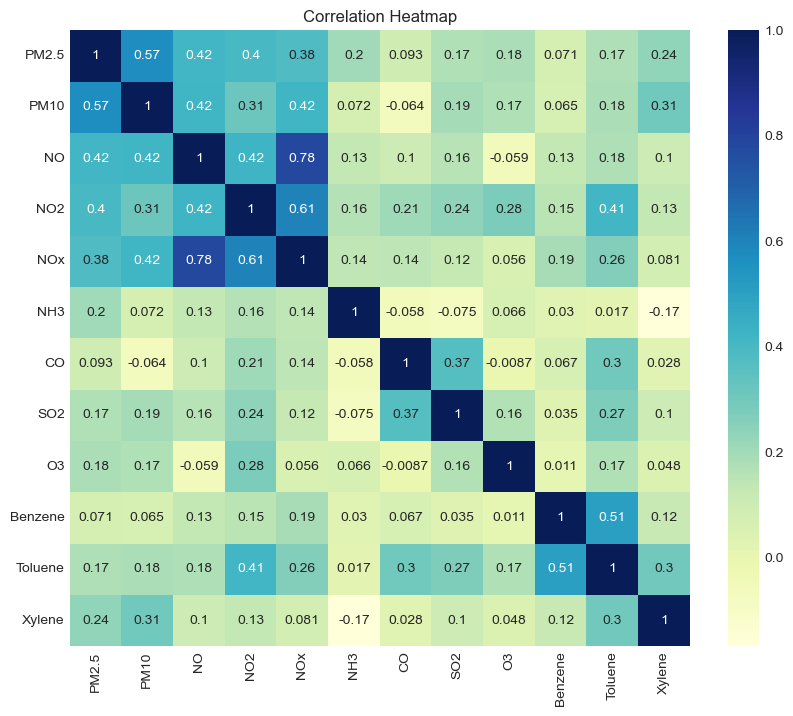

In [450]:
#Correlation heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')

### We also compare the condition number to check for multicollinearity and as it is less than 30 we can conclude that there is no multicollinearity.

In [451]:
eigenvalues = np.linalg.eigvals(correlation_matrix)
condition_number = np.sqrt(np.max(eigenvalues) / np.min(eigenvalues))

# Display the condition number
print("Condition Number:", condition_number)

Condition Number: 4.563285166144656


#### We observe that the condition number of 4.56 is relatively low. Lower condition numbers are indicative of better numerical stability, and a value below 30 is often considered satisfactory. Given this condition number, it suggests that the numerical stability of my regression coefficients is not a major concern. This implies that the coefficients are not highly sensitive to small changes in the data due to multicollinearity.

## 13. Model Selection

In [452]:
from itertools import combinations

### We perform both forward AIC for model selection and removing unnecessary features in the model.

In [453]:
# Function to fit a model and calculate AIC
def calculate_aic(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    aic = model.aic
    return aic

# Forward Stepwise AIC
def forward_stepwise_aic(X, y):
    best_features = []
    remaining_features = list(X.columns)
    current_aic = float('inf')

    while remaining_features:
        best_aic = float('inf')
        best_feature = None

        for feature in remaining_features:
            candidate_features = best_features + [feature]
            aic = calculate_aic(X[candidate_features], y)

            if aic < best_aic:
                best_aic = aic
                best_feature = feature

        if best_aic < current_aic:
            current_aic = best_aic
            best_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break

    return best_features

# Backward Stepwise AIC
def backward_stepwise_aic(X, y):
    features = list(X.columns)
    best_features = features.copy()
    current_aic = calculate_aic(X[best_features], y)

    while len(features) > 1:
        best_aic = float('inf')
        worst_feature = None

        for feature in features:
            candidate_features = [f for f in best_features if f != feature]
            aic = calculate_aic(X[candidate_features], y)

            if aic < best_aic:
                best_aic = aic
                worst_feature = feature

        if best_aic < current_aic:
            current_aic = best_aic
            best_features.remove(worst_feature)
        else:
            break

    return best_features

# Forward Stepwise AIC
forward_selected_features = forward_stepwise_aic(X_train_log, y_train_log)
print("Forward Stepwise AIC Selected Features:", forward_selected_features)

# Backward Stepwise AIC
backward_selected_features = backward_stepwise_aic(X_train_log, y_train_log)
print("Backward Stepwise AIC Selected Features:", backward_selected_features)

print("Selected Features for the model:", forward_selected_features)

Forward Stepwise AIC Selected Features: ['PM2.5', 'CO', 'PM10', 'O3', 'NOx', 'NH3', 'SO2', 'Xylene', 'Toluene', 'NO2', 'NO']
Backward Stepwise AIC Selected Features: ['const', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Toluene', 'Xylene']
Selected Features for the model: ['PM2.5', 'CO', 'PM10', 'O3', 'NOx', 'NH3', 'SO2', 'Xylene', 'Toluene', 'NO2', 'NO']


### As we can see the features that have been excluded in the forward AIC and backward AIC is the same and that is Benzene.

In [454]:
final_df = df_without_outliers_log.drop(columns = ['Benzene'])
final_df

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Toluene,Xylene,AQI
28,83.130,0.000,6.930,28.710,33.720,0.000,6.930,49.520,59.760,0.000,3.140,5.347
29,79.840,0.000,13.850,28.680,41.080,0.000,13.850,48.490,97.070,0.000,4.810,5.796
35,58.360,0.000,2.600,21.390,23.310,0.000,2.600,32.660,53.540,0.000,0.000,5.011
36,79.290,0.000,1.160,26.940,26.830,0.000,1.160,67.410,59.300,0.000,0.000,5.252
37,88.700,0.000,7.290,31.320,37.730,0.000,7.290,80.090,44.760,0.000,0.000,5.513
...,...,...,...,...,...,...,...,...,...,...,...,...
29526,15.020,50.940,7.680,25.060,19.540,12.470,0.470,8.550,23.300,12.070,0.730,3.738
29527,24.380,74.090,3.420,26.060,16.530,11.990,0.520,12.720,30.140,2.210,0.380,4.263
29528,22.910,65.730,3.450,29.530,18.330,10.710,0.480,8.420,30.960,0.010,0.000,4.234
29529,16.640,49.970,4.050,29.260,18.800,10.030,0.520,9.840,28.300,0.000,0.000,4.007


In [455]:
X = final_df.drop(columns = ['AQI'])
Y = final_df['AQI']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
X_train_with_const = sm.add_constant(X_train)
model_statsmodels = sm.OLS(y_train, X_train_with_const).fit()

### We drop Benzene from the dataset and evaluate the model again.

In [456]:
print(model_statsmodels.summary())

                            OLS Regression Results                            
Dep. Variable:                    AQI   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     7222.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:53:20   Log-Likelihood:                -277.70
No. Observations:               17969   AIC:                             579.4
Df Residuals:                   17957   BIC:                             673.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8995      0.005    850.164      0.0

## 14. Checking for Model Accuracy and Cross Validation - Dataset after transformation

### We check model accuracy by testing on a X Test Dataset and calculating R2 Score and Mean Square Error.

In [457]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.06330750053118825
R-squared (R2): 0.8123659334699125


### We further check model accuracy by using 5 Fold Cross Validation on X parameters Dataset and calculating it's R2 Score and Mean Square Error.

In [458]:
# Define a custom scoring function for cross-validation based on R-squared
scorer = make_scorer(r2_score)

# Perform cross-validation
cv_scores = cross_val_score(model, X, Y, cv=5, scoring=scorer)

# Print the cross-validation scores
print("Cross-Validation R-squared Scores:")
print(cv_scores)

# Print the average R-squared score
print(f"Average R-squared Score: {np.mean(cv_scores)}")

Cross-Validation R-squared Scores:
[0.77475177 0.78294202 0.80426823 0.69705237 0.81832745]
Average R-squared Score: 0.7754683685092718


### Now we plot Cross Validated Predictions against the Actual Values and we can see a change in the graph.

Cross-validated R-squared Score: 0.8154191766556712


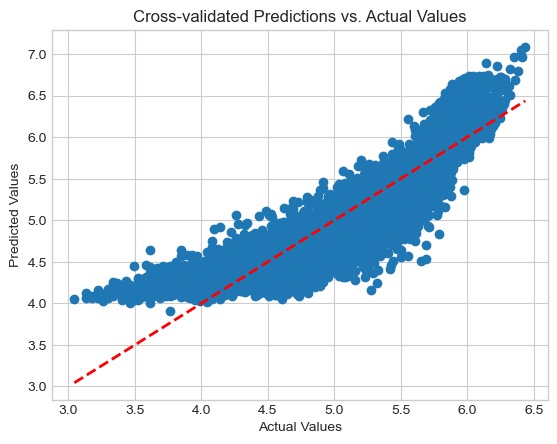

In [459]:
# Perform cross-validated predictions
y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5)

# Evaluate the R-squared score on the training set
r2_cv = r2_score(y_train, y_pred_cv)
print(f"Cross-validated R-squared Score: {r2_cv}")

# Plot the predicted vs. actual values
plt.scatter(y_train, y_pred_cv)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Cross-validated Predictions vs. Actual Values')
plt.show()

## 15. Tracing the values of Adjusted R-squared, MSE, and Cross Validated R-squared score

In [460]:
#Tracing

# Sample data
data = {
    'Initial Model': [0.852, 3702.7705, 60.85, 0.8508],
    'Model after observation outlier removal': [0.910, 1002.604, 31.66, 0.910],
    'Model after log transformation': [0.816, 0.0633, 0.251, 0.815],
    'Model after AIC': [0.816, 0.0633, 0.251, 0.815]
}

# Row labels
row_labels = ['Adjusted R-squared', 'Mean Squared Error', 'Root Mean Squared Error', 'Cross Validated R-squared Score']

# Create a DataFrame
trace_df = pd.DataFrame(data, index=row_labels)
trace_df

,Initial Model,Model after observation outlier removal,Model after log transformation,Model after AIC
Adjusted R-squared,0.852,0.910,0.816,0.816
Mean Squared Error,3702.771,1002.604,0.063,0.063
Root Mean Squared Error,60.850,31.660,0.251,0.251
Cross Validated R-squared Score,0.851,0.910,0.815,0.815


## 16. Conclusion

### FINAL REGRESSION EQUATION:

### AQI = 3.8995 + 0.0082(PM2.5) + 0.0013(PM10) – 0.0004(NO) + 0.0003(NO2) + 0.0011(NOx) + 0.0007(NH3) + 0.0663(CO) + 0.0016(SO2) + 0.0035(O3) – 0.0008(Toluene) - 0.0016(Xylene)

### Adjusted R-squared - 0.816. Hence, we can imply that 81.6 % of the variance in the AQI is explained by the regressor variables.

### Each of the regressors have a p-value greater lesser than 0.05, which implies that each of them are significant in calculating AQI.

In [461]:
# Sample data
data = {
    'Final Model': [0.816, 0.0633, 0.251, 0.815]
}

# Row labels
row_labels = ['Adjusted R-squared', 'Mean Squared Error', 'Root Mean Squared Error', 'Cross Validated R-squared Score']

# Create a DataFrame
trace_df = pd.DataFrame(data, index=row_labels)
trace_df

,Final Model
Adjusted R-squared,0.816
Mean Squared Error,0.063
Root Mean Squared Error,0.251
Cross Validated R-squared Score,0.815
